# Construction of a Non-Unitary Operator
## Linear Combination of Unitaries
by <a href="https://www.linkedin.com/in/la-wun-nannda-b047681b5/">`La Wun Nannda`</a>

### Prepare an Environment

In [1]:
# import libraries
from classiq import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# initiate a session
authenticate()

C:\Users\ASUS\anaconda3\envs\qiskit_env\Lib\site-packages\classiq\_internals\authentication\token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


### Problem 
Apply the non-unitary matrix
\begin{pmatrix}
1 & 0\\
0 & 0
\end{pmatrix}
on a 1-qubit quantum state which has a 0.3 probability being measured in the zero state $|0\rangle$.

### My Solution

According to the problem, we need to create a non-unitary matrix:
$\begin{pmatrix}
1 & 0\\
0 & 0
\end{pmatrix}$. Let's call that matrix $A$.

Given $P(0)=0.3$, we know $P(1)=0.7$. 
- Our `initial target qubit` will be $|\psi\rangle=\sqrt{0.3}|0\rangle+\sqrt{0.7}|1\rangle$.
- The `control qubit` is initiated as $|0\rangle$.

We know that a non-unitary matrix $A$ can be constructed by summing the unitary matrices with their respective coefficients (alpha values).

$$A = \sum_{i} \alpha_iU_i$$

When we build a circuit, the main <b>SELECT</b> component is implemented within two <b>PREPARE</b> circuits that cancel each other's effect in the end. 
- The purpose of a <b>PREPARE</b> circuit is to prepare alpha values.
- The <b>SELECT</b> gate is constructed from the identity and Z gates, given our non-unitary.

$$A = \alpha_0I + \alpha_1Z$$

When we apply $A$ on our qubit $|\psi\rangle$, we get $|\psi'\rangle$. 

$$|\psi'\rangle=\frac{1}{\lambda}A|\psi\rangle$$

$\frac{1}{\lambda}$ is called the normalization factor and we will not consider that here to reduce complexity. Therefore, 

$$|\psi'\rangle=
A|\psi\rangle= 
\begin{pmatrix}
1 & 0\\
0 & 0
\end{pmatrix}
\times
\begin{pmatrix}
0.3\\
0.7
\end{pmatrix}=
\begin{pmatrix}
0.3\\
0
\end{pmatrix}$$

This tells us that our `final qubit` should in the state 0. Mathematically, it is $|\psi'\rangle=\sqrt{0.3}|0\rangle$.

### Implement Functions

In [3]:
# a function for linear combination of unitaries
@qfunc
def lcu_controllers(controller: QNum, psi: QNum):
    control(ctrl=controller == 0, operand=lambda: I(psi))

    control(ctrl=controller == 1, operand=lambda: Z(psi))

In [4]:
# the main function
@qfunc
def main(controller: Output[QNum], psi: Output[QNum]):

    # Defining the error bound and probability distribution
    error_bound = 0.01
    controller_probabilities = [0.3, 0.7]

    # Allocating the target and control qubits, respectively
    allocate(1, psi)
    allocate(1, controller)

    # Executing the Within-Apply function, the SELECT function is defined by lcu_controllers and the PREPARE function is defined by the inplace_prepare_state function.
    within_apply(
        compute=lambda: inplace_prepare_state(
            probabilities=controller_probabilities, bound=error_bound, target=controller
        ),
        action=lambda: lcu_controllers(controller, psi),
    )

### Build and Execute a Model

In [5]:
# create a model
quantum_model = create_model(main)

In [6]:
# synthesize it
quantum_program = synthesize(quantum_model)

In [7]:
# display the program circuit
show(quantum_program)

Opening: https://platform.classiq.io/circuit/53c1d1a0-e9f9-4926-b984-08e8203c9db7?version=0.43.2


We will execute our program for 2048 shots.

In [8]:
# execute the program
job = execute(quantum_program)

# store results
result = job.result()[0].value
print(result.parsed_counts,'\n')

[{'controller': 0.0, 'psi': 0.0}: 2048] 



### Evaluate the Outcome

In [9]:
# check result
result

ExecutionDetails(vendor_format_result={}, counts={'00': 2048}, counts_lsb_right=True, parsed_states={'00': {'controller': 0.0, 'psi': 0.0}}, histogram=None, output_qubits_map={'controller': (0,), 'psi': (1,)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'controller': (1,), 'psi': (0,)}, num_shots=2048)

In [10]:
# prepare output data for a bar-graph
qubits = []
counts = []
for k in result.counts.keys():
    qubits.append(k)
for v in result.counts.values():
    counts.append(v)

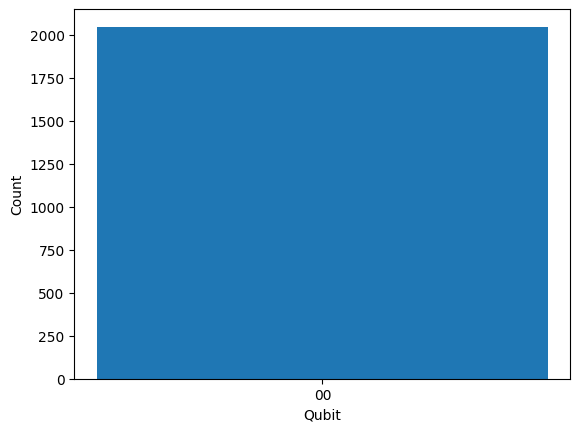

In [11]:
# display a bar-graph
x = np.array(qubits)
y = np.array(counts)
plt.bar(x,y)
plt.xlabel("Qubit")
plt.ylabel("Count")
plt.show()

### Conclusion
#### Expectation
The control qubit is initiated as 0, goes through some transformations, and returns back to `0` because of the <b>PREPARE</b> and <b>PREPARE'</b> circuits. The final target qubit $|\psi'\rangle$ should be `0` according to above calculations.
#### Outcome
From our bar-graph, we know that we get `00` for 2048 times out of 2048 shots. This is a 100% probability. The value `00` is also consistent with the expected control and target qubits. Therefore, we can conclude that our output is what we expected. We have successfully implemented a non-unitary matrix $A$.